In [85]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [86]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [87]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15952821965390890366
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12004650165440762226
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [88]:
from tensorflow.keras.layers import  Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D,BatchNormalization,ReLU,Conv2D,GlobalAvgPool2D,Dense,ReLU,Activation,Add
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Reshape
from tensorflow.keras import backend as K

### MobieNet Bottleneck block

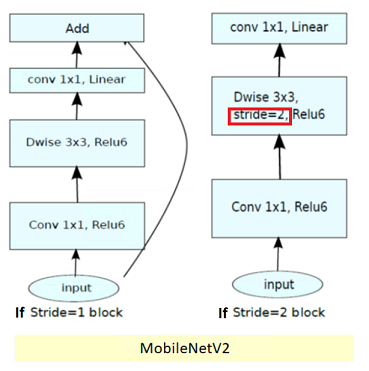

### MobineNetV2 Architecture

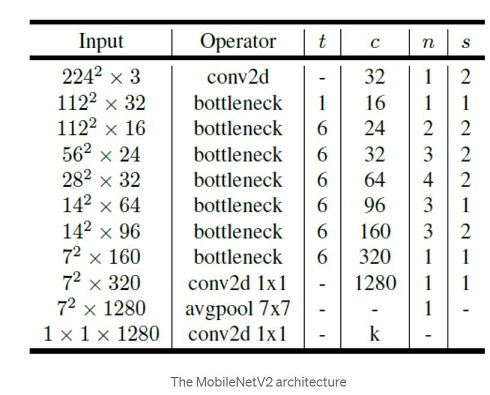

In [98]:
def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)

In [99]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [100]:
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)

In [101]:
def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x

In [102]:
def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)

    return x

In [103]:
def MobileNetv2(input_shape, classes, alpha=1.0): 
  
  inputs = Input(shape=input_shape)

  first_filters = _make_divisible(32 * alpha, 8)
  print("first_filters:",first_filters)

  x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

  x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
  x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
  x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
  x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
  x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
  x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
  x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

  if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
  else:
      last_filters = 1280

  x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
  x = GlobalAveragePooling2D()(x)
  x = Reshape((1, 1, last_filters))(x)
  x = Dropout(0.3, name='Dropout')(x)
  x = Conv2D(classes, (1, 1), padding='same')(x)

  x = Activation('softmax', name='softmax')(x)
  output = Reshape((classes,))(x)

  model = Model(inputs, output)

  return model



In [105]:
model = MobileNetv2((224,224,3),3)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )


first_filters: 32


In [106]:
% cd /content/drive/MyDrive/ComputerVision/dataset/ImgClassification

/content/drive/MyDrive/ComputerVision/dataset/ImgClassification


In [107]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')

room_types = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')
print (room_types)  #what kinds of rooms are in this dataset

print("Types of rooms found: ", len(dataset_path))

['bed_room', 'dining_room', 'living_room']
Types of rooms found:  3


In [108]:
rooms = []

for item in room_types:
 # Get all the file names
 all_rooms = os.listdir('rooms_dataset' + '/' +item)
 #print(all_shoes)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('rooms_dataset' + '/' +item) + '/' + room))
    print(rooms)

[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1303451__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/b

In [109]:
# Build a dataframe        
rooms_df = pd.DataFrame(data=rooms, columns=['room type', 'image'])
print(rooms_df.head())

  room type                                              image
0  bed_room  rooms_dataset/bed_room/architecture-modern-hou...
1  bed_room        rooms_dataset/bed_room/bed-1048194__340.jpg
2  bed_room        rooms_dataset/bed_room/bed-1846251__340.jpg
3  bed_room        rooms_dataset/bed_room/bed-1303451__340.jpg
4  bed_room    rooms_dataset/bed_room/bed-4540208__340 (1).jpg


In [110]:
# Let's check how many samples for each category are present
print("Total number of rooms in the dataset: ", len(rooms_df))

room_count = rooms_df['room type'].value_counts()

print("rooms in each category: ")
print(room_count)

Total number of rooms in the dataset:  37
rooms in each category: 
living_room    14
bed_room       12
dining_room    11
Name: room type, dtype: int64


In [111]:
import cv2
path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/'

im_size = 224

images = []
labels = []

for i in room_types:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [112]:
images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(37, 224, 224, 3)

In [113]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
y=rooms_df['room type'].values
#print(y[:5])

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [114]:
y=y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder

# binary encode
onehot_encoder = OneHotEncoder(categories='auto',sparse=False)
Y = onehot_encoder.fit_transform(y)

In [115]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(35, 224, 224, 3)
(35, 3)
(2, 224, 224, 3)
(2, 3)


In [116]:
model.fit(train_x, train_y, epochs = 3, batch_size = 32)

Epoch 1/3
2/2 [==============================] - 39s 783ms/step - loss: 1.4901 - accuracy: 0.3714
Epoch 2/3
2/2 [==============================] - 0s 72ms/step - loss: 1.4522 - accuracy: 0.4571
Epoch 3/3
2/2 [==============================] - 0s 75ms/step - loss: 0.8829 - accuracy: 0.6286


Input image shape: (1, 224, 224, 3)


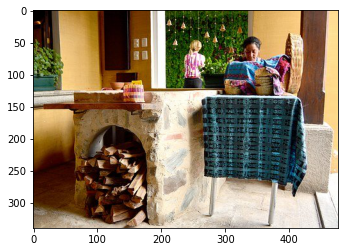

In [117]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/dining_room/dining-room-1420457__340.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [118]:
print(model.predict(x))

[[0.32996246 0.33243367 0.33760387]]
